[![](https://img.shields.io/badge/launch-jupyter-blue)](https://mybinder.org/v2/gh/tuw-geo/tuw_education_notebooks/15bcbc542b9c50306617af6f796bb6c8fd4fcf0d?urlpath=lab%2Ftree%2F02_counterexample.de.ipynb)

![Bild vom [wikipedia](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)


In [1]:
import xarray as xr

from pathlib import Path
from tuw_education_notebooks.view_monthly_ssm import view_monthly_ssm, load_cmap

RESOURCES = Path("data")

## Wissenschaft und Kunst

Die Datenvisualisierung stützt sich auf die Kunst, um durch die Kombination von geometrischen Objekten und Farben mit wissenschaftlichen Elementen Geschichten aus Daten zu vermitteln. Im Idealfall sollten die Informationen leicht aus der Visualisierung extrahierbar sein, aber gleichzeitig sollten die wissenschaftlichen Elemente auf den Punkt genau sein. Letzteres ist wichtig, da falsche grafische Darstellungen zu einer falschen Wahrnehmung und Interpretation führen können, was wiederum zu falschen Entscheidungen führt. Diese Fehler können absichtlich gemacht werden und somit betrügerisch sein, aber häufiger sind es unschuldige Fehler mit potenziell weitreichenden Folgen. Bei der Darstellung von Daten auf Karten müssen wir noch weitere Aspekte berücksichtigen, wie z. B. die geografische Projektion, Gittertypen und die Abbildung von Variablen als dritte Dimension in einem geeigneten Farbraum.

## TU Wien Oberflächen-Bodenfeuchte entwickelt für GHG-Kit

Für die Beispiele in diesem Notizbuch werden wir die für GHG-Kit entwickelte Bodenfeuchte verwenden. Um Daten über die Bodenfeuchte zu erhalten, nutzen wir die allgemeine lineare Beziehung zwischen der Sentinel-1-Mikrowellenrückstreuung und der Bodenfeuchte. Die an der TU Wien entwickelte Methode zur Erkennung von Veränderungen lässt sich in einfachen Worten so zusammenfassen, dass der trockenste und der feuchteste Zustand innerhalb eines Zeitraums berechnet wird und dann die beobachtete Rückstreuung in Beziehung gesetzt wird, um die relative Bodenfeuchte oder „Nässe“ in Prozent zu ermitteln, wie in @fig-change dargestellt.

![Methode zur Erkennung von Veränderungen bei der Bestimmung der Bodenfeuchtigkeit.](assets/images/ssm_retrieval_change_detection.png){#fig-change}

Für die Beispiele werden wir eine Teilmenge von Daten über Österreich zeigen. In Österreich gibt es zwei große Herausforderungen für die Bodenfeuchte, nämlich:

- Ausgeprägte geometrische Effekte durch unterschiedliche Blickwinkel aufgrund der variablen Topographie in und um die Alpen.
- Starke Vegetationsbedeckung über dichten Wäldern.

Im Bodenfeuchteprodukt, das für GHG-Kit entwickelt wurde, gehen wir diese Herausforderungen an, indem wir **radiometrische geländekorrigierte Rückstreudaten** verwenden, um das Gelände zu „glätten“, und statische räumliche Filterung von **dichter Vegetation** bei hoher Auflösung (siehe Anhang).

In den folgenden Zeilen laden wir eine Teilmenge des Bodenfeuchtedatensatzes mit „xarray“, der als Zarr-Archiv gespeichert ist.


In [2]:
SSM_dc = xr.open_zarr(RESOURCES / "SSM-CD-SIG40-R-DVEG_2018.zarr/")
SSM_dc

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 723, y: 1200, x: 1200)
Coordinates:
  * time         (time) datetime64[ns] 6kB 2018-01-01T05:08:47 ... 2018-12-31...
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
Data variables:
    band_data    (time, y, x) float64 8GB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    spatial_ref  int64 8B ...

We resample this dataset along the time dimension thereby aggregating surface soil moisture as mean values over months.


In [3]:
SSM_dc_monthly = SSM_dc.resample(time="ME").mean()
SSM_dc_monthly

<xarray.Dataset> Size: 138MB
Dimensions:      (time: 12, y: 1200, x: 1200)
Coordinates:
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
  * time         (time) datetime64[ns] 96B 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    band_data    (time, y, x) float64 138MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    spatial_ref  (time) int64 96B 0 0 0 0 0 0 0 0 0 0 0 0

## Wie man seine Karte (nicht) einfärbt

Jetzt können wir die Bodenfeuchtigkeitsdaten auf einer Karte darstellen. Um eine Variable wie die Bodenfeuchte in den Dimensionen x (Längengrad) und y (Breitengrad) darzustellen, muss eine gute Darstellung in einem 3D-Farbraum gefunden werden. Dies wird auch als Pseudofärbung bezeichnet: eine Methode zur Darstellung von Aspekten der Daten in einer kontinuierlichen Ebene. Für eine effektive Pseudofärbung müssen wir die richtige Farbkarte finden.  Wir können uns die folgenden Fragen stellen:

- Was wissen wir über die Daten. Gibt es z. B. einen kritischen Wert, mit dem die Daten verglichen werden können?
- Gibt es ein intuitives Farbschema, das die Variable einschließlich der Verteilung der Daten gut wiedergibt?

Wir können zwischen den folgenden Arten von Farbkarten wählen:

- Sequentiell: Die Schritte im Variablenraum entsprechen den Schritten im Farbraum (einheitliche Farbkarten).
- Divergierend: wenn wir einen kritischen Mittelwert haben, mit dem wir die Daten vergleichen wollen.
- Qualitativ: wenn es sich um ungeordnete kategoriale Daten handelt.

## Das Schlechte

In den folgenden Karten sehen wir, was schief gehen kann, wenn diese Aspekte nicht berücksichtigt werden.


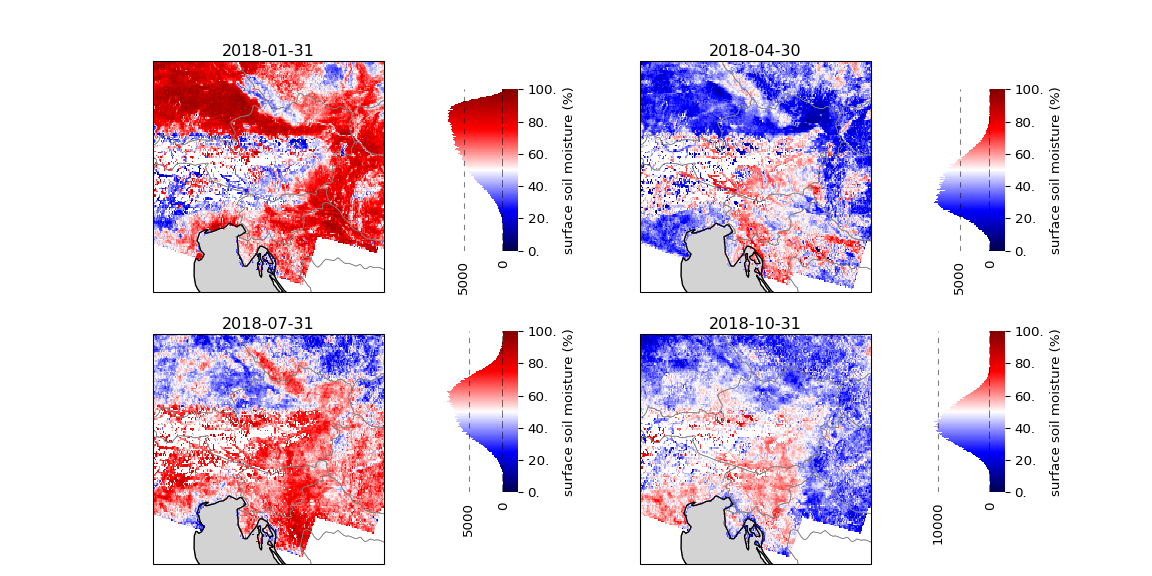

In [4]:
#| label: fig-seismic
#| fig-cap: 'Monatliche aggregierte Bodenfeuchte (%) für Januar, April, Juli und Oktober 2018, abgerufen mit dem für das GHG-Kit Projekt entwickelten Algorithmus der TU Wien. Karten erstellt mit EOmaps [@quast_getting_2024].'
view_monthly_ssm(SSM_dc_monthly, "seismic")

Was ist bei den obigen Karten falsch gelaufen? Der erste Fehler ist, dass wir eine divergierende Farbkarte genommen haben, obwohl die Daten keinen kritischen Mittelwert haben. Der scharfe Kontrast zwischen Blau und Rot lässt es außerdem so aussehen, als ob die Daten binär wären, aber in Wirklichkeit haben wir gleichmäßig verteilte Werte aus einer Stichprobenverteilung, die sich einer Normalverteilung annähert (wie aus den Histogrammen ersichtlich ist). Darüber hinaus haben wir eine Farbkarte gewählt, die Weiß enthält. Es gibt auch Informationen in dem, was wir auf dieser Karte nicht sehen: z. B. fehlende Datenpunkte. Durch die Wahl der Farbe Weiß wird jedoch der falsche Eindruck erweckt, dass Daten fehlen, obwohl die Bodenfeuchtigkeit in Wirklichkeit bei 50 % liegt.

## Das Hässliche

Lassen wir das erste Problem beheben. Dazu wählen wir die sequenzielle „viridis“-Farbkarte. Bei dieser Farbkarte ist die Farbe eine lineare Funktion der Variablen mit einem sehr breiten Wahrnehmungsbereich (d. h. sie ist sehr bunt). Viridis ist außerdem farbenblindheitsfreundlich und druckt gut in Graustufen, wobei die Einheitlichkeit der Wahrnehmung und die Breite des Spektrums erhalten bleiben.


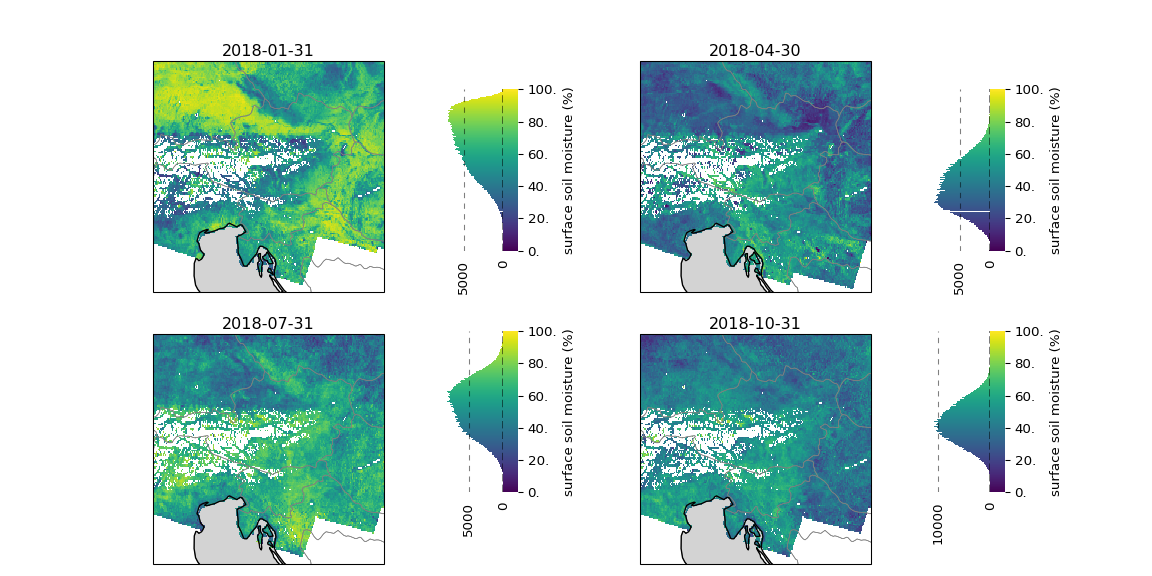

In [5]:
#| label: fig-viridis
#| fig-cap: 'Monatliche aggregierte Bodenfeuchte (%) für Januar, April, Juli und Oktober 2018, abgerufen mit dem für das GHG-Kit Projekt entwickelten Algorithmus der TU Wien. Karten erstellt mit EOmaps [@quast_getting_2024].'
view_monthly_ssm(SSM_dc_monthly, "viridis")

Diese Farbkarte behebt die vorherigen Probleme. Wir sehen viel mehr Nuancen in der Varianz der Bodenfeuchtigkeit. In erster Linie sehen wir auch, dass wir tatsächlich fehlende Datenpunkte haben. Es gibt ein ganzes Gebiet in den Alpen, das nicht gut abgedeckt ist. Das ist eigentlich ein bekannter Effekt der Messtechnik. Wir können nicht alle geometrischen Effekte mit der radiometrischen Geländekorrektur in der Mikrowellen-Fernerkundung ausgleichen. In sehr steilen Regionen wie den Alpen müssen wir die Daten aufgrund von Abschattungen und Überlagerungseffekten maskieren. Abschattungen treten auf, wenn das Gelände so steil ist, dass es die Sicht auf nachfolgende Punkte versperrt, so dass keine Messungen möglich sind und die Rekonstruktion der Szene behindert wird (weitere Informationen siehe Anhang). 

## Das Gute

Dieser letzte Schritt ist eher subjektiv und bezieht sich auf die Psychologie der Farben: die vielfältigen Bedeutungen und Gefühle, die Menschen mit einer Farbe verbinden. Hier verwenden wir einen von der TU Wien entwickelten linearen Farbverlauf von braun für trockene Böden bis blau für nasse Böden.


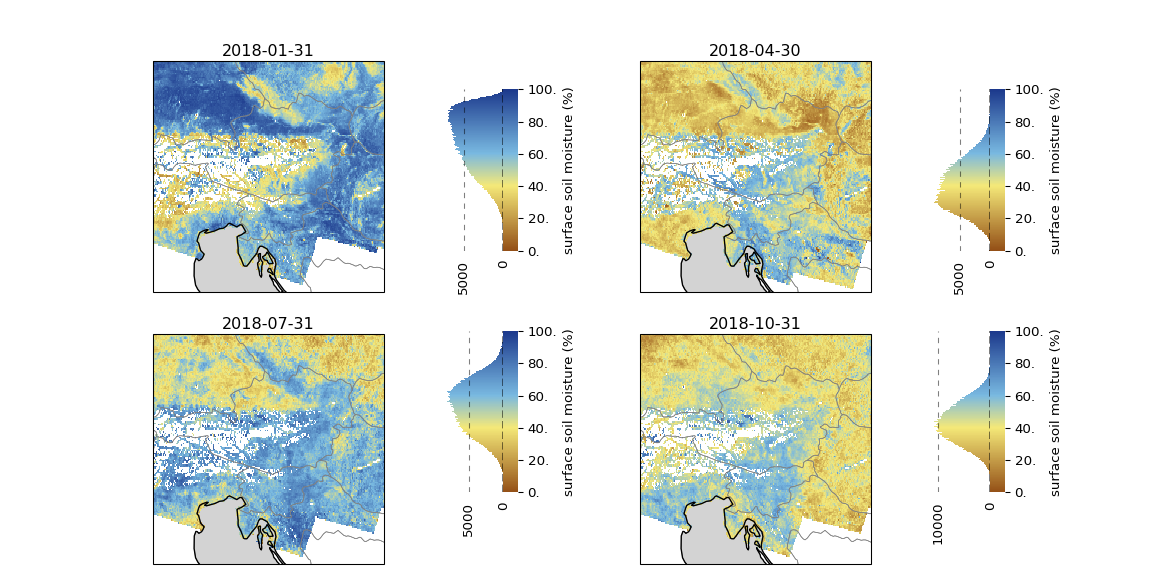

In [6]:
#| label: fig-custom
#| fig-cap: 'Monatliche aggregierte Bodenfeuchte (%) für Januar, April, Juli und Oktober 2018, abgerufen mit dem für das GHG-Kit Projekt entwickelten Algorithmus der TU Wien. Karten erstellt mit EOmaps [@quast_getting_2024].'
SSM_CMAP = load_cmap(RESOURCES / "colour-tables/ssm-continuous.ct")
view_monthly_ssm(SSM_dc_monthly, SSM_CMAP)

In dieser letzten Wiedergabe der Karten zeigt sich eine schöne lineare Beziehung zwischen Farbe und Bodenfeuchtigkeit, wobei die braune Farbe an ausgetrocknete Böden und die blaue Farbe an wassergesättigte Bedingungen erinnert.

---

## Anhang

### Radiometrische Geländekorrektur
Die Mikrowellen-Rückstreuung ist stark vom Betrachtungswinkel abhängig, d.h. die gemessene Rückstreuung variiert stark, je nachdem aus welchem Winkel wir auf den Boden blicken. Der Einfallswinkel, unter dem der Boden von einem Sentinel-1-Sensor aus gesehen wird, hängt von seiner Umlaufbahn ab. Um dies zu korrigieren, entwickelte @bauer-marschallinger_toward_2019 eine Methode zur Normalisierung auf einen gemeinsamen Einfallswinkel von 40 Grad. Diese Methode geht jedoch von einer relativ flachen Topografie aus und kann in steilem und abwechslungsreichem Gelände versagen. Daher verwenden wir ein hochauflösendes digitales Höhenmodell (DEM), um die Rückstreuung in hoher Auflösung zu korrigieren, bevor wir auf 500 Meter hochtakten und auf den gemeinsamen Einfallswinkel normalisieren.

### Filterung von dichter Vegetation
Dichte Vegetation kann das Signal des Bodens behindern, oder es kann so schwach sein, dass es nicht von Rauschen zu unterscheiden ist. Um das Signal über dicht bewachsenen Gebieten zu verstärken, hat @massart_mitigating_2024 eine räumliche Filtermethode entwickelt, mit der dichte Vegetation bei hoher Auflösung maskiert wird, bevor das Upsampling auf 500 m erfolgt.

### Abschattung und Überlagerung
Layover tritt auf, weil das Mikrowellenradar die Entfernung zwischen dem Sensor und einem Punkt auf dem Boden misst. In sehr steilem und hohem Gelände ist das Gelände „näher“ am Sensor, wodurch sich die gemessene Entfernung verkürzt und der Punkt vor anderen im Raster erscheint.